In [1]:
!pip install --upgrade git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-82mjdzal
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-82mjdzal
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.12.0.dev0+264.g9d731721c-cp36-cp36m-linux_x86_64.whl size=16257343 sha256=ff5a63b63a01e0e8a28a6f5841ec2476744a4823bb3689726a4b4bb77f3faab5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fpk3gdjz/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore") # warnings を表示させないようにする

In [5]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers1949-1960.csv to AirPassengers1949-1960 (1).csv


### データフレームとしてデータセットを読み込む

In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['AirPassengers1949-1960.csv']),
                 parse_dates = ["Month"],
                 index_col = ["Month"],
                 dtype = {'#Passengers':'float'})

In [7]:
print(df.head())
print(df.tail())

            #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
            #Passengers
Month                  
1960-08-01        606.0
1960-09-01        508.0
1960-10-01        461.0
1960-11-01        390.0
1960-12-01        432.0


### 折れ線グラフを表示
データをもらったら、まずは基礎中継や可視化を実施する。
飛行機の乗客数は季節に依存し、「夏は需要が高く、冬は低い」という傾向がある。

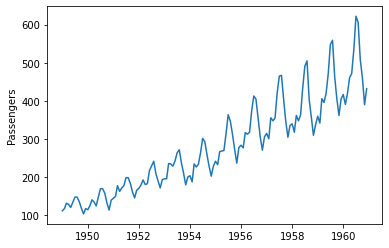

In [10]:
plt.plot(df["#Passengers"])
plt.ylabel("Passengers");

####  １９５８年までの訓練データを取得して、残り２年間を予測してみるストーリー

In [0]:
train = df[:"1958-12-31"]

In [0]:
from fbprophet import Prophet

In [0]:
# データの整形
train = train.reset_index().rename(columns={'Month':'ds', '#Passengers': 'y'})

In [19]:
# 三角関数の数はデフォルト通りの10を指定
m = Prophet(growth = "linear", # トレンドでつなぎ合わせる関数。ロジスティック曲線にする場合は"logistic"に変更する
            yearly_seasonality = 10,
            weekly_seasonality = False,
            daily_seasonality = False, 
            seasonality_mode='multiplicative').fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
# 予測期間2年間の指定 'MS'で自動的に月初めのみのデータフレームを用意。'M'だと月末。
future = m.make_future_dataframe(periods = 24, freq='MS')

In [0]:
 forecast = m.predict(df = future)

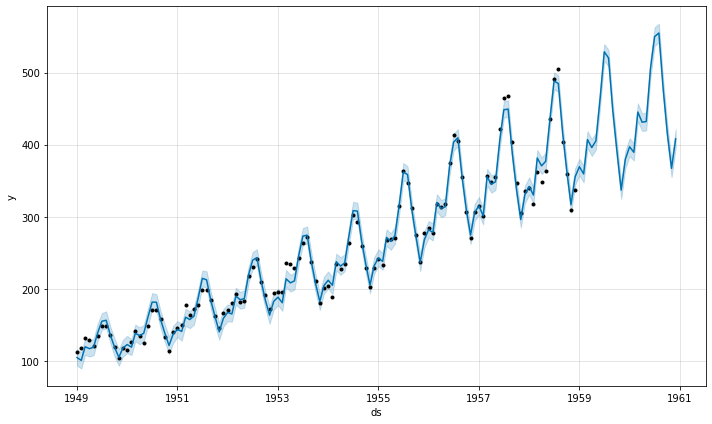

In [24]:
fig = m.plot(forecast)
# 黒点がtrain(訓練データ)の観測値、青線が予測値とあてはめの値、水色の帯が80%信頼区間を表示

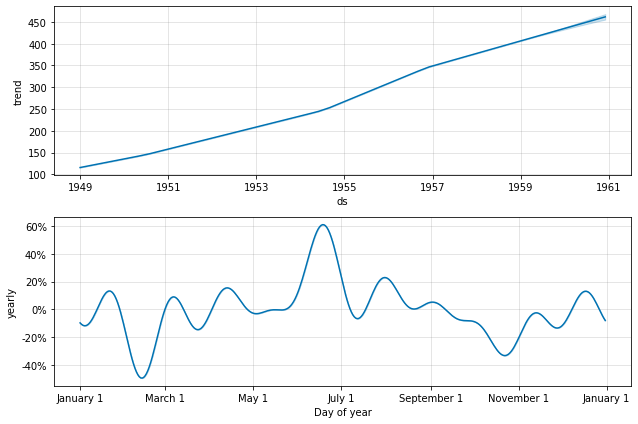

In [26]:
fig = m.plot_components(forecast)
# 図の1つ目はトレンドの推移を表している。
# 図の2つ目は推定された年収木の効果を表している。

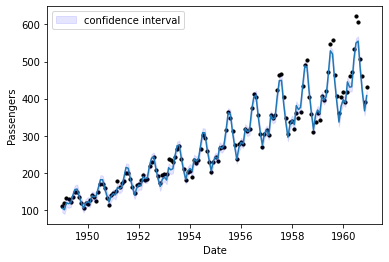

In [30]:
# 実際のデータと比較する
plt.scatter(df.index, df["#Passengers"], color = "black", s = 10) # 実測値のプロット（散布図）
plt.plot(forecast["ds"], forecast["yhat"]) # 予測値のプロット（折れ線）

# 区間予測の描画
plt.fill_between(df.index,
                 forecast["yhat_upper"],
                 forecast["yhat_lower"],
                 color='blue', alpha=.1, label="confidence interval")

plt.xlabel('Date') # x軸の名前
plt.ylabel('Passengers') # y軸の名前
plt.legend();

In [32]:
# 予測値と実測値の誤差を算出する
observed = np.array(df.tail(24)["#Passengers"])
pred = np.array(forecast.tail(24)["yhat"])
resid = observed - pred

print(resid)

[ -9.39734086 -17.37437124  -0.99577264   0.09570461  14.86880775
   7.41000255  19.21154775  38.77632348  16.10201694  15.9679489
  25.12373835  25.49220752  19.9758087    1.62823705 -26.19110476
  29.91035576  39.96511932  29.49344965  72.19036441  51.1396074
  30.18526975  44.72772379  22.93219855  23.98081556]


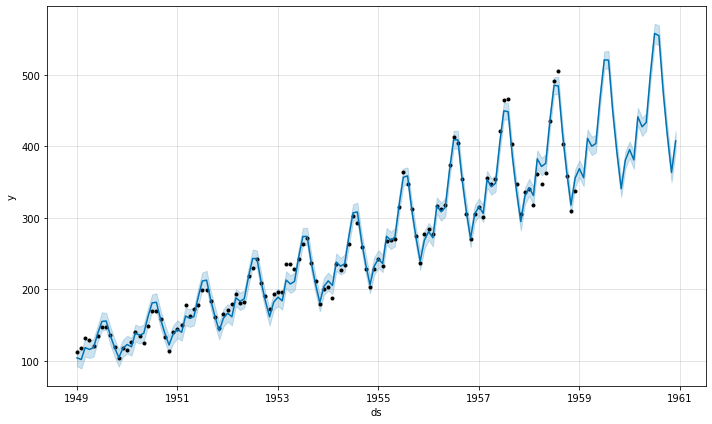

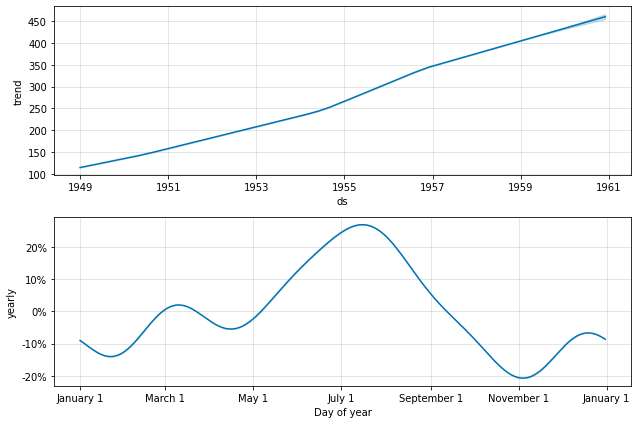

In [34]:
m2 = Prophet(growth = "linear",
             yearly_seasonality = 5, # より単純な周期を表すように三角関数の数を減らした
             weekly_seasonality = False,
             daily_seasonality = False,
             seasonality_mode='multiplicative').fit(train)
forecast2 = m2.predict(df = future)
fig = m2.plot(forecast2)
fig = m2.plot_components(forecast2)
# 年周期を5とした倍は当てはめと予測の結果はほとんど変わらないが、よりなめらかで、月初めと月末の間などデータのない区間でもまともな周期成分が推定されている。

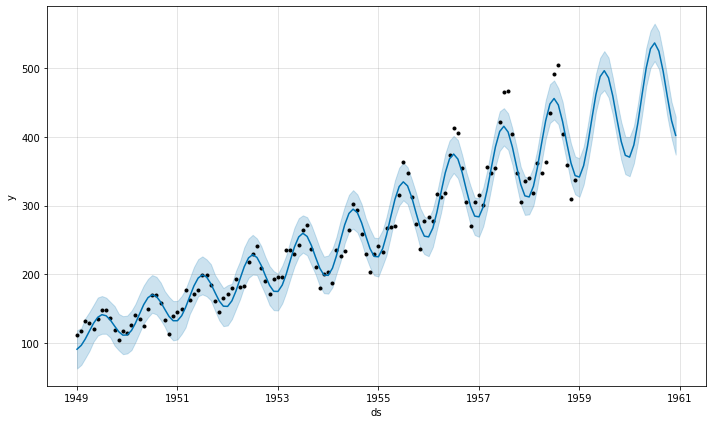

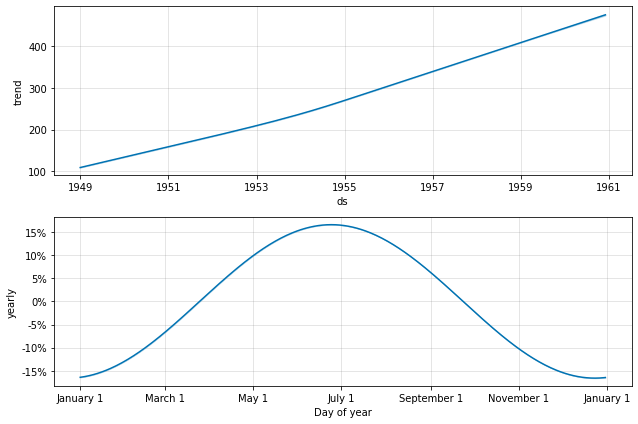

In [35]:
m2 = Prophet(growth = "linear",
             yearly_seasonality = 1, # もっと単純化
             weekly_seasonality = False,
             daily_seasonality = False,
             seasonality_mode='multiplicative').fit(train)
forecast2 = m2.predict(df = future)
fig = m2.plot(forecast2)
fig = m2.plot_components(forecast2)
# 年周期が単純になりすぎて、当てはまりが悪くなった。

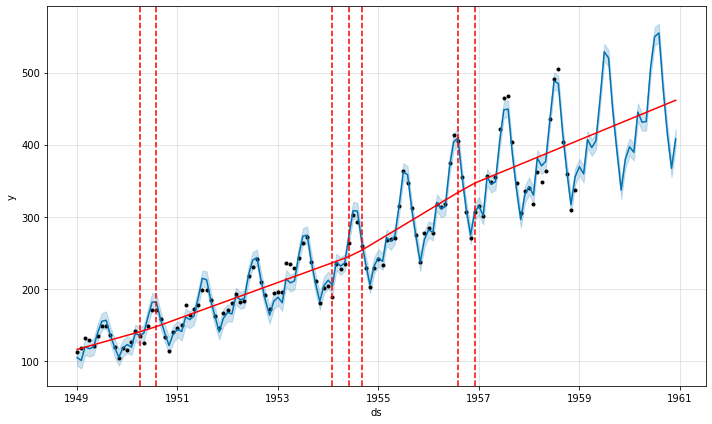

In [36]:
# トレンドの変化点を可視化するコード
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# トレンドがどの時点で変化が起きたのか。候補点のうち7個で変化したと推定された。

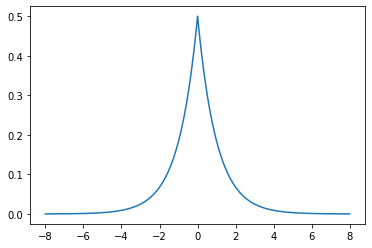

In [39]:
# ラプラス分布を表示するコード
scale = 1
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x)/scale)/(2.*scale)
plt.plot(x, pdf);
# ラプラス分布は両側指数分布とも呼ばれる
# スケールパラメータ（広がりを制御するパラメータ）が１のラプラス分布の確率密度関数を表示。中央の平均のところが急激に尖っており、0が多くなるように推定されるであろうことが伺える

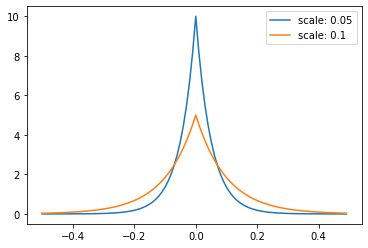

In [40]:
# スケールパラメータを調整してラプラス分布の形が変わることを確認する
x = np.arange(-0.5, 0.5, .01)
scale1 = 0.05
scale2 = 0.1

pdf_05 = np.exp(-abs(x)/scale1)/(2.*scale1)
pdf_1 = np.exp(-abs(x)/scale2)/(2.*scale2)
plt.plot(x, pdf_05, label = "scale: 0.05")
plt.plot(x, pdf_1, label = "scale: 0.1")
plt.legend();

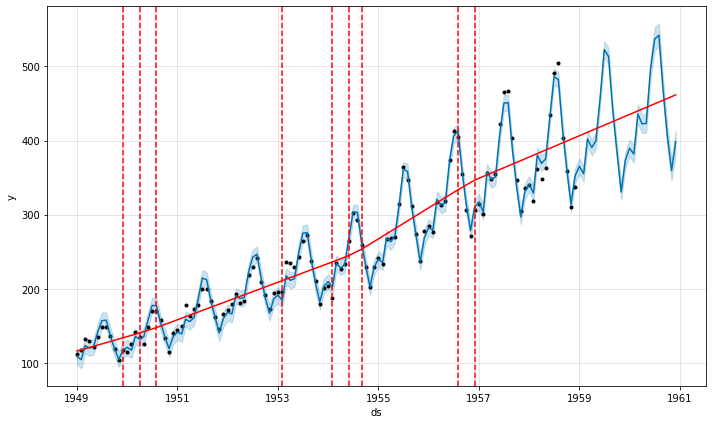

In [41]:
# ラプラス分布のスケールパラメータを大きくすることで、選ばれる変化点の数が増えることを確認する
m4 = Prophet(growth = "linear",
             yearly_seasonality = 10,
             weekly_seasonality = False,
             daily_seasonality = False,
             seasonality_mode='multiplicative',
             changepoint_prior_scale=0.1).fit(train)
forecast4 = m4.predict(df = future)
fig4 = m4.plot(forecast4)
a = add_changepoints_to_plot(fig4.gca(), m4, forecast)
# トレンドの変化点は9個になって、デフォルトのときよりも多くなっている。
# 季節周期の場合と同様、モデルをより複雑にするべきか、より単純にするべきか、予測精度などに基づいて吟味する必要がある。

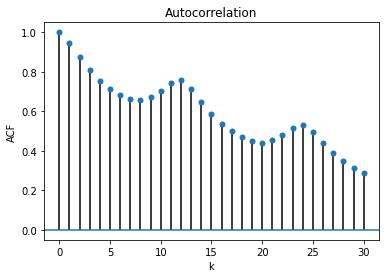

In [45]:
# 飛行機乗客データの自己相関関数をプロットする
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df["#Passengers"], lags = 30, alpha = None)
plt.xlabel("k")
plt.ylabel("ACF");